In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.classification import accuracy_score, log_loss

from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score

warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# Loading datasets


In [2]:
# Loading training_variants
data_variants = pd.read_csv('training/training_variants')
# Loading training_text dataset,seperated by ||
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(5)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    Our data is composed of 4 features <br>
    <ul>
        <li><b>ID : </b>row id used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> class value 1-9, this genetic mutation has been classified on</li>
    </ul>

In [4]:
data_variants.shape

(3321, 4)

In [5]:
data_text.head(5)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


We see the above dataset contain only two features: ID and the text. We have to preprocess the text also.

In [6]:
data_text.shape

(3321, 2)

In [7]:
# Data present in class column
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [8]:
#Let start processing the text file. We need to remove the stop words irrelvant to our goal like english prepositions.
#We will remove these useless words called stop words with NLTK library.
stop_words = set(stopwords.words('english'))


So, we have to deal with a Multi class classification problem.


# Data preprocessing


In [9]:

#Let define a function for that.
def data_text_(text_file, indx, col):
    # Remove int values from the text dataset
    if type(text_file) is not int:
        my_string = ""
        # replacing all special char with space
        text_file = re.sub('[^a-zA-Z0-9\n]', ' ', str(text_file))
        # replacing multiple spaces with a single space
        text_file = re.sub('\s+',' ', str(text_file))
        # text lower-case 
        text_file = text_file.lower()        
        for word in text_file.split():
            if not word in stop_words:
                my_string += word + " "
        
        data_text[col][indx] = my_string
    

In [10]:

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_(row['TEXT'], index, 'TEXT')

In [11]:
#Now we are merging both dataset (ID is in common feature) in order to have a unified dataset and focus better in our classification goal.
genetic_dataset=pd.merge(data_variants,data_text,on='ID',how='left')
genetic_dataset.head(5)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
#Next, we are removing spaces on text of each column of variation and gene with '_'
genetic_dataset.Gene      = genetic_dataset.Gene.str.replace('\s+', '_')
genetic_dataset.Variation = genetic_dataset.Variation.str.replace('\s+', '_')


In [13]:
#Next we are checking for missing values
genetic_dataset.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [14]:
#In order to deal with missing values we chose not to remove the rows but to concat the info from Gene and Variation in respective missing places.
genetic_dataset.loc[genetic_dataset['TEXT'].isnull(),'TEXT'] = genetic_dataset['Gene'] +' '+genetic_dataset['Variation']

In [15]:
#Let check again for missing values
genetic_dataset.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         0
dtype: int64

In [16]:
#X= genetic_dataset.drop("Class",axis=1)
#Y=genetic_dataset.Class
Y = genetic_dataset['Class'].values
# Now, we are splitting our data into train, test and cross validation
# Splitting the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(genetic_dataset, Y, test_size=0.2)
# split the train data now into train validation and cross validation
x_train_cv, x_test_cv, y_train_cv, y_test_cv= train_test_split(X_train, y_train,test_size=0.2)


In [17]:
#Let verify how the split of data is going
print('Number of data points in train data:', x_train_cv.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', x_test_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [18]:
train_data_distrib = x_train_cv['Class'].value_counts().sort_values()
test_data_distrib = X_test['Class'].value_counts().sort_values()
cv_data_distrib = x_test_cv['Class'].value_counts().sort_values()

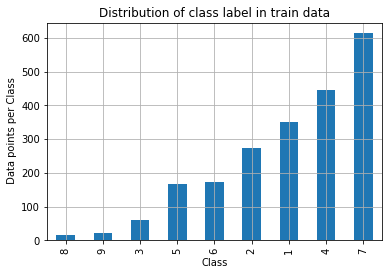

In [19]:
train_data_distrib.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Data points per Class')
plt.title('Distribution of class label in train data')
plt.grid()
plt.show()

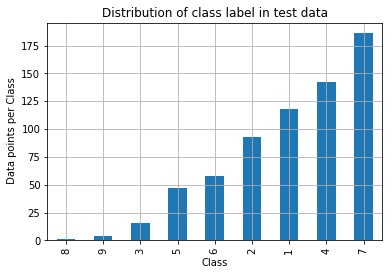

In [20]:
test_data_distrib.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Data points per Class')
plt.title('Distribution of class label in test data')
plt.grid()
plt.show()

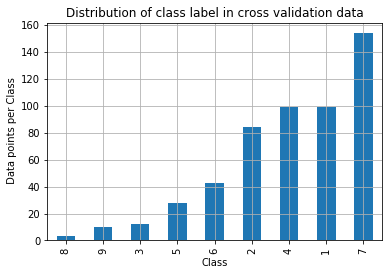

In [21]:
cv_data_distrib.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Data points per Class')
plt.title('Distribution of class label in cross validation data')
plt.grid()
plt.show()

In [22]:

#We need to convert our categorical variables into numerical for bulding machine learning algorithms
#Let start with gene column
#One hot encoding for gene column
gene_vector=CountVectorizer()
train_gene_oneHotCod=gene_vector.fit_transform(x_train_cv['Gene'])
test_gene_oneHotCod=gene_vector.transform(X_test['Gene'])
cv_gene_oneHotCod=gene_vector.transform(x_test_cv['Gene'])
#final_train, final_test = train_gene_oneHotCod.align(test_gene_oneHotCod, join='inner', axis=1) 

In [23]:
print(train_gene_oneHotCod.shape)
print(test_gene_oneHotCod.shape)
print(cv_gene_oneHotCod.shape)

(2124, 235)
(665, 235)
(532, 235)


In [24]:
#Let create Response encoding for gene
def feat_dict(alpha, feature, df):
    # value_count: it contains a dict 
    # print(X_train['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    
    #         ...}
   
    value_count = x_train_cv[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gene_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, val in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(X_train.loc[(train_df['Class']==1) & (X_train['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
      
            # nr_rows.shape[0] will return the number of rows

            nr_rows = x_train_cv.loc[(x_train_cv['Class']==k) & (x_train_cv[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((nr_rows.shape[0] + alpha*10)/ (val + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gene_dict[i]=vec
    return gene_dict

# creating list from dictionary of probabilities
def gv_feature(alpha, feature,df):
    # print(gene_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #   ...
    #     }
    gv_dict = feat_dict(alpha, feature, df)
    
    value_count = x_train_cv[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [25]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(gv_feature(alpha, "Gene", x_train_cv))
# test gene feature
test_gene_feature_responseCoding = np.array(gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(gv_feature(alpha, "Gene", x_test_cv))

In [26]:
print(train_gene_feature_responseCoding )

[[0.12087912 0.10989011 0.10989011 ... 0.10989011 0.10989011 0.10989011]
 [0.09433962 0.11320755 0.09433962 ... 0.16037736 0.09433962 0.09433962]
 [0.17647059 0.08403361 0.08403361 ... 0.09243697 0.08403361 0.08403361]
 ...
 [0.0862069  0.10344828 0.0862069  ... 0.25862069 0.0862069  0.0862069 ]
 [0.13978495 0.10752688 0.10752688 ... 0.10752688 0.10752688 0.10752688]
 [0.06410256 0.22435897 0.06410256 ... 0.32051282 0.06410256 0.06410256]]


In [27]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [28]:
test_gene_feature_responseCoding.shape

(665, 9)

In [29]:
cv_gene_feature_responseCoding.shape

(532, 9)

In [30]:
# one-hot encoding of variation feature.
variation_vector = CountVectorizer()
train_variation_oneHotCod=variation_vector.fit_transform(x_train_cv['Variation'])
test_variation_oneHotCod=variation_vector.transform(X_test['Variation'])
cv_variation_oneHotCod=variation_vector.transform(x_test_cv['Variation'])


In [31]:
print(train_variation_oneHotCod.shape)
print(test_variation_oneHotCod.shape)
print(cv_variation_oneHotCod.shape)

(2124, 1963)
(665, 1963)
(532, 1963)


In [32]:
#Encoding response for variation
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(gv_feature(alpha, "Variation", x_train_cv))
# test gene feature
test_variation_feature_responseCoding = np.array(gv_feature(alpha, "Variation", X_test))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(gv_feature(alpha, "Variation", x_test_cv))

In [33]:
train_variation_feature_responseCoding.shape


(2124, 9)

In [34]:
#Function1: count of each word
#Function 2 : for response encoding

def create_dictionary(text):
    dictionary = defaultdict(int)
    for index, row in text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

create_dictionary(genetic_dataset)

defaultdict(int,
            {'cyclin': 13219,
             'dependent': 18497,
             'kinases': 10205,
             'cdks': 592,
             'regulate': 3520,
             'variety': 3150,
             'fundamental': 611,
             'cellular': 12158,
             'processes': 2641,
             'cdk10': 130,
             'stands': 107,
             'one': 40728,
             'last': 2389,
             'orphan': 74,
             'activating': 15128,
             'identified': 38268,
             'kinase': 65798,
             'activity': 76677,
             'revealed': 12187,
             'previous': 11289,
             'work': 3738,
             'shown': 43895,
             'silencing': 1497,
             'increases': 2946,
             'ets2': 300,
             'v': 8144,
             'ets': 2282,
             'erythroblastosis': 33,
             'virus': 1777,
             'e26': 19,
             'oncogene': 5571,
             'homolog': 1280,
             '2': 154194,
   

In [35]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_encoding= np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_encoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_encoding

In [36]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train_cv['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()


In [37]:
dict_list = []
# dict_list =[] contains 9 dictionaries where each corresponds to the respective class
for i in range(1,10):
    text = x_train_cv[x_train_cv['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(create_dictionary(text))
    # append it to dict_list
#Two main distinctions:
# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = create_dictionary(x_train_cv)

propab_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    propab_array.append(ratios)
propab_array = np.array(propab_array)

In [38]:
print(propab_array )

[[0.07913669 0.02574782 0.00492238 ... 0.12040894 0.00454373 0.00605831]
 [0.13601103 0.1049819  0.01206689 ... 0.34614722 0.01137735 0.01913463]
 [0.09615385 0.125      0.09615385 ... 0.20192308 0.09615385 0.09615385]
 ...
 [0.11578947 0.12631579 0.10526316 ... 0.11578947 0.10526316 0.10526316]
 [0.125      0.125      0.10416667 ... 0.125      0.10416667 0.10416667]
 [0.11881188 0.0990099  0.0990099  ... 0.16831683 0.0990099  0.11881188]]


In [39]:
train_text_feature_responseCoding  = get_text_responsecoding(x_train_cv)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_test_cv)

In [40]:
train_text_feature_responseCoding.shape

(2124, 9)

In [41]:
print(train_text_feature_responseCoding)

[[0.17363412 0.11680869 0.02111846 ... 0.26688421 0.01218932 0.01570655]
 [0.10574516 0.11176147 0.02216889 ... 0.29604386 0.0108249  0.01372112]
 [0.18735015 0.07936642 0.02812517 ... 0.19940188 0.0089235  0.0114052 ]
 ...
 [0.12470814 0.12051046 0.02097346 ... 0.34756313 0.01063369 0.01274833]
 [0.18046692 0.1205543  0.02247107 ... 0.27326138 0.01304552 0.0173808 ]
 [0.08711202 0.15708303 0.01810066 ... 0.40189393 0.00857724 0.01075219]]


In [42]:
# https://stackoverflow.com/a/16202486
# Here we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [43]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(x_test_cv['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [44]:
#Let check dimensions
print(train_text_feature_onehotCoding.shape )
print(test_text_feature_onehotCoding.shape)
print(cv_text_feature_onehotCoding.shape)

(2124, 53768)
(665, 53768)
(532, 53768)


In [45]:
#toxsr() return a copy of the matrix in Compressed Sparse Row format
train_gene_var_onehotCoding = hstack((train_gene_oneHotCod,train_variation_oneHotCod))
print(train_gene_oneHotCod.shape)
print(train_variation_oneHotCod.shape)
test_gene_var_onehotCoding = hstack((test_gene_oneHotCod,test_variation_oneHotCod))
cv_gene_var_onehotCoding = hstack((cv_gene_oneHotCod,cv_variation_oneHotCod))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
print(train_gene_var_onehotCoding.shape)
print(train_text_feature_onehotCoding.shape)
train_y = np.array(list(x_train_cv['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding , cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_test_cv['Class']))


(2124, 235)
(2124, 1963)
(2124, 2198)
(2124, 53768)


In [46]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55966)
(number of data points * number of features) in test data =  (665, 55966)
(number of data points * number of features) in cross validation data = (532, 55966)


In [47]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [48]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


In [49]:
def report_log_loss(train_x, train_y, test_x, test_y,  model):
    model.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(train_x, train_y)
    calib_clf_probs = calib_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [54]:

def predict_confusion_matrix(train_x, train_y,test_x, test_y, model):
    model.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(model, method="sigmoid")
    calib_clf.fit(train_x, train_y)
    pred_y = calib_clf.predict(test_x)

    # for calculating log_loss we will use the array of probabilities that belongs to each class
    print("Log loss :",log_loss(test_y, calib_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of miss-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    #print("accuracy:", 100*(1-missclassified))

# Building ML models


Naive Bayes <br>
https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/ <br>
Why using CalibratedClassifierCV here?
"The distribution of the probabilities can be adjusted to better match the expected distribution observed in the data. This adjustment is referred to as calibration, as in the calibration of the model or the calibration of the distribution of class probabilities."

In [55]:
from sklearn import metrics
alpha = [  0.0001, 0.1, 1, 10, 100,1000]
error=[]
for i in alpha:
    print("for alpha", i)
    naive_model=MultinomialNB(alpha=i)
    naive_model.fit(train_x_responseCoding,train_y)
    calib = CalibratedClassifierCV(naive_model, method="sigmoid")
    calib.fit(train_x_responseCoding, train_y)
    calib_probs = calib.predict_proba(cv_x_responseCoding)
    error.append(log_loss(cv_y, calib_probs,labels=naive_model.classes_,  eps=1e-15))
    #print("Log Loss :",log_loss(cv_y, calib_probs)) 
    print("Log loss :",log_loss(cv_y, calib_probs))


for alpha 0.0001
Log loss : 1.2109276220807628
for alpha 0.1
Log loss : 1.2099833502802146
for alpha 1
Log loss : 1.2173085041704932
for alpha 10
Log loss : 1.252399591131639
for alpha 100
Log loss : 1.251400396205438
for alpha 1000
Log loss : 1.2496780996744952


So, we are using alpha =0.1 in our test data.

In [68]:
naive_model=MultinomialNB(alpha=0.0001)
naive_model.fit(train_x_responseCoding,train_y)
calib = CalibratedClassifierCV(naive_model, method="sigmoid")
calib.fit(train_x_responseCoding, train_y)
pred_y = calib.predict_proba(train_x_responseCoding)
print("For alpha =0.1, train log is",log_loss(train_y, pred_y, labels=naive_model.classes_, eps=1e-15))
pred_y = calib.predict_proba(cv_x_responseCoding)
print("For alpha =0.1, cv log is",log_loss(cv_y, pred_y, labels=naive_model.classes_, eps=1e-15))
pred_y_test = calib.predict_proba(test_x_responseCoding)
print("For alpha =0.1, test log is",log_loss(test_y, pred_y_test, labels=naive_model.classes_, eps=1e-15))

For alpha =0.1, train log is 1.1784946543522627
For alpha =0.1, cv log is 1.2109276220807628
For alpha =0.1, test log is 1.2440043083646297


In [57]:
predict_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, naive_model)

Log loss : 1.2109276220807628
Number of mis-classified points : 0.45112781954887216


In [58]:
predict_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, naive_model)

Log loss : 1.2902952153260763
Number of mis-classified points : 0.39473684210526316


K Nearest neighbor

In [59]:
alpha = [5, 10,  21, 35,  55, 99]
error = []
for i in alpha:        
    print("for alpha",i)
    cluster_model=KNeighborsClassifier(n_neighbors=i)
    cluster_model.fit(train_x_responseCoding, train_y)
    calib = CalibratedClassifierCV(cluster_model, method="sigmoid")
    calib.fit(train_x_responseCoding, train_y)
    calib_probs = calib.predict_proba(cv_x_responseCoding)
    error.append(log_loss(cv_y, calib_probs, labels=cluster_model.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, calib_probs))

for alpha 5
Log Loss : 1.037604485082537
for alpha 10
Log Loss : 1.006227971613474
for alpha 21
Log Loss : 1.0326418723020077
for alpha 35
Log Loss : 1.0296972840198777
for alpha 55
Log Loss : 1.0510129170644373
for alpha 99
Log Loss : 1.0636314828143534


We choose alpha 10 with lowest log loss

In [67]:
cluster_modell=KNeighborsClassifier(n_neighbors=5)
cluster_modell.fit(train_x_responseCoding, train_y)
pred_y_test = calib.predict_proba(test_x_responseCoding)
print("For lowest log loss of alpha, test log is",log_loss(test_y, pred_y_test, labels=cluster_modell.classes_, eps=1e-15))

For lowest log loss of alpha, test log is 1.125207970118624


In [61]:
predict_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, cluster_modell)

Log loss : 1.037604485082537
Number of mis-classified points : 0.3383458646616541


In [62]:
predict_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, cluster_modell)

Log loss : 1.327763268229588
Number of mis-classified points : 0.4642857142857143


Logistic regression

In [63]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.0420880698467974
for alpha = 1e-05
Log Loss : 1.0426781350838845
for alpha = 0.0001
Log Loss : 1.0551401365943935
for alpha = 0.001
Log Loss : 1.1498797391009932
for alpha = 0.01
Log Loss : 1.2053689840229729
for alpha = 0.1
Log Loss : 1.214508950185464
for alpha = 1
Log Loss : 1.2705474706772824
for alpha = 10
Log Loss : 1.5221829954610397
for alpha = 100
Log Loss : 1.5656728712814847


In [64]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-10))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.358880682164992
for alpha = 1e-05
Log Loss : 1.3488457069460353
for alpha = 0.0001
Log Loss : 1.3439974514203643
for alpha = 0.001
Log Loss : 1.1358334391920262
for alpha = 0.01
Log Loss : 1.1504374016595937
for alpha = 0.1
Log Loss : 1.3061517713024013
for alpha = 1
Log Loss : 1.5489871002814704


In [65]:
clff = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=42)
clff.fit(train_x_onehotCoding, train_y)
predict_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clff)

Log loss : 1.1504374016595937
Number of mis-classified points : 0.34962406015037595


In [66]:
predict_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clff)

Log loss : 1.2031839686110826
Number of mis-classified points : 0.4492481203007519
